In [33]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np

from src.GridWorldMDP.objectworld_utils import draw_path, generate_demonstrations, init_object_world, visitation_frequency
from src.deepmaxent_irl_objectworld import run_deepmaxent_irl
from src.maxent_irl_objectworld import run_maxent_irl
from src.img_utils import Visualizer, get_evd, draw_evd
from src.argument_parser import get_parser, parse_args_str

PARSER = get_parser()

In [34]:
np.random.seed(1)
BASIC_ARGS = """
--exp_name test
--height 6
--n_objects 12
--n_colours 2
--height 8
--width 8
--seed 2
--n_trajs 10
--n_query 1
--device cpu
"""
args = parse_args_str(PARSER, BASIC_ARGS)
print(args.exp_name)

init_start_pos = np.random.randint(0, args.height, size=(args.n_query, 2)).tolist()
print('start positions: ', init_start_pos)

env, P_a, rewards_gt, values_gt, policy_gt, feat_map = init_object_world(args)
feat_map.shape

test
start positions:  [[5, 3]]
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration


(64, 4)

In [35]:
import torch
import torch.nn as nn
from src.deepmaxent_irl import demo_svf

trajs = generate_demonstrations(env, policy_gt, 
                                n_trajs=args.n_query, 
                                len_traj=args.l_traj, 
                                rand_start=True, 
                                start_pos=None)
device = torch.device(args.device)
N_STATES, _, N_ACTIONS = np.shape(P_a)
mu_D = demo_svf(trajs, N_STATES)
inputs = torch.from_numpy(feat_map).float().to(device)
inputs.size()

torch.Size([64, 4])

In [38]:
m = nn.Dropout(0.25)
x = torch.randn(2, 3)
m(x)

tensor([[ 2.1936,  0.3852, -1.6616],
        [-2.8745, -0.5671, -0.0000]])

In [11]:
input_dim = 2*args.n_colours
height = np.sqrt(inputs.size(0)).astype(int)
inputs_img = inputs.view(height, height, input_dim).permute(2, 1, 0)[None,]

idx = 16
print(env.idx2pos(idx))
print(inputs[16, :])
print(inputs_img[0, :, 0, 2])

(0, 2)
tensor([2.2361, 2.0000, 2.0000, 2.2361])
tensor([2.2361, 2.0000, 2.0000, 2.2361])


In [12]:
from collections import Counter
hiddens = [32, 32, 16, 16, 8]
Counter(hiddens)

Counter({32: 2, 16: 2, 8: 1})

In [13]:
from collections import Counter

def build_block(input_dim, output_dim, kernel_size=3, stride=1, padding=1, dropout=0.25):
    return [
        nn.Conv2d(input_dim, output_dim, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.ELU(),
        nn.Dropout(dropout)
    ]

class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c,  downsample=None):
        super().__init__()
        self.conv = nn.Sequential(
            *build_block(in_c, out_c, kernel_size=3, stride=1, padding=1)
        )
        self.act = nn.ELU()
        self.downsample = downsample
        self.out_c = out_c

    def forward(self, x):
        identity = x
        out = self.conv(x)
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        out = self.act(out)
        return out

class DeepIRLCNN(nn.Module):
    def __init__(self, input_dim, hiddens: list[int], output_dim: int=1):
        super(DeepIRLCNN, self).__init__()
        self.input_dim = input_dim
        self.hiddens = hiddens
        self.output_dim = output_dim
        self.layers = nn.ModuleList()
        
        # init block always build additional blocks as the same dim with hiddens[0]
        # e.g. out_channel = hiddens = [32, 32, 16, 16, 8]
        # first layer channel: input_dim > 32
        # layers = {32: 2, 16: 2, 8: 1}
        self.in_c = hiddens[0]
        blocks_count = Counter(hiddens)
        self.layers.append(nn.Sequential(*build_block(input_dim, self.in_c)))
        for out_c, n_blocks in blocks_count.items():
            self.layers.append(self.build_layers(out_c, n_blocks))
            
        # last layer
        self.layers.append(nn.Sequential(
            nn.Conv2d(self.in_c, output_dim, kernel_size=1, stride=1, padding=0),
            nn.Tanh()
        ))

    def build_layers(self, out_c, n_blocks):
        downsample = None
        if self.in_c != out_c:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_c, out_c, kernel_size=1, stride=1, padding=0),
                nn.ELU()
            )
        layers = []
        layers.append(ResidualBlock(self.in_c, out_c, downsample))
        self.in_c = out_c
        for l in range(1, n_blocks):
            layers.append(ResidualBlock(self.in_c, out_c, downsample=None))
        return nn.Sequential(*layers)
              
    def forward(self, x):
        """Get reward"""
        grid_size = int(np.sqrt(x.size(0)))
        # x: SxD -> 1xDxHxW
        x = x.view(grid_size, grid_size, self.input_dim).permute(2, 1, 0)[None,]
        for i, layer in enumerate(self.layers):
            x = layer(x)
        x = x.squeeze()  # 1x1xHxW -> HxW
        # x: 1xHxW -> Sx1
        return x.permute(1, 0).reshape(-1, 1)

In [48]:
output_dim = 1
hiddens = [32, 32, 16, 16, 8]
input_dim = 2*args.n_colours
model = DeepIRLCNN(input_dim, hiddens, output_dim)
o = model(inputs)

Layer 0
torch.Size([1, 4, 8, 8])
Layer 1
torch.Size([1, 32, 8, 8])
Layer 2
torch.Size([1, 32, 8, 8])
Layer 3
torch.Size([1, 16, 8, 8])
Layer 4
torch.Size([1, 8, 8, 8])


## Maxent

In [ ]:
MAXENT_ARGS = """
--exp_name maxent_rand
--type object
--n_objects 7
--n_colours 4
--height 32
--width 32
--gamma 0.8
--act_random 0.3
--n_trajs 5
--l_traj 6
--learning_rate 0.1
--n_iters 10
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 0.5
--active
--seed 2
"""
args = parse_args_str(PARSER, MAXENT_ARGS)
print(args.exp_name)

history_maxent_active = run_maxent_irl(args, init_start_pos=init_start_pos)

In [ ]:
visualizer = Visualizer(history_maxent_active, file_path=None)
search_idx = 9
visualizer.draw_value_maps(search_idx)
visualizer.draw_acq_maps(search_idx)

---

## Deep Maxent

In [25]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np

from src.GridWorldMDP.objectworld_utils import draw_path, generate_demonstrations, init_object_world, visitation_frequency
from src.deepmaxent_irl_objectworld import run_deepmaxent_irl
from src.maxent_irl_objectworld import run_maxent_irl
from src.img_utils import Visualizer, get_evd, draw_evd
from src.argument_parser import get_parser, parse_args_str

PARSER = get_parser()

In [29]:
DEEP_MAXENT_ACTIVE_ARGS = """
--exp_name deepmaxent_active
--type object
--n_objects 12
--n_colours 2
--height 6
--width 6
--gamma 0.9
--act_random 0.3
--n_trajs 40
--l_traj 8
--learning_rate 0.02
--n_iters 50
--alpha 0.1
--n_query 4
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 2.0
--hiddens 4 4
--device cuda
--active
--seed 2
--verbose 2
--architecture dnn
"""

# becareful of learning rate will cause nan
args = parse_args_str(PARSER, DEEP_MAXENT_ACTIVE_ARGS)
print(args.exp_name)
history_deepmaxent_active = run_deepmaxent_irl(args, init_start_pos=None)

deepmaxent_active
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
[INFO] Initialize trajectories
Visitation Frequency
[[0 0 0 0 0 0]
 [2 0 0 0 0 0]
 [5 1 2 1 0 5]
 [5 0 0 2 3 5]
 [0 0 0 0 1 0]
 [0 0 0 0 0 0]]
[INFO - n_trajs:4] Training Deep MaxEnt IRL


  0%|          | 0/50 [00:00<?, ?it/s]

[[-0.2182 -0.2948 -0.4911 -0.5372 -0.6091 -0.6389]
 [ 0.4264  0.142  -0.2963 -0.4899 -0.3211 -0.4899]
 [ 0.4556  0.2961 -0.2624 -0.2483 -0.0558  0.0427]
 [-0.2345 -0.3016 -0.4409 -0.3273 -0.0308  0.142 ]
 [-0.4461 -0.502  -0.2214  0.1368  0.0995  0.0637]
 [-0.4663 -0.637  -0.2854 -0.2472 -0.1592 -0.278 ]]
[INFO - n_trajs:4] Policy evaluation
-- evd = 0.430249 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.298283 ---
[INFO - n_trajs:4] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:4--
[[3.5761 4.0895 4.1503 4.6602 4.6351 4.0175]
 [4.1549 3.9937 3.5598 4.5442 4.8761 4.2508]
 [4.0622 3.9132 3.7063 5.4183 6.0349 5.5026]
 [3.0398 3.6347 5.1064 6.3535 6.606  6.1936]
 [2.7967 4.0878 5.6225 6.4732 6.9217 6.4484]
 [3.5158 5.0969 5.9487 6.3714 6.4632 6.0366]]
[INFO - n_trajs:4] Generating a new demonstrations from [(4, 4), (3, 4), (4, 3), (5, 4)]
Visitation Frequency
[[ 0  0  0  0  0  0]
 [ 2  0  0  0 

  0%|          | 0/50 [00:00<?, ?it/s]

[[-0.093  -0.2186 -0.4991 -0.5822 -0.6898 -0.726 ]
 [ 0.5575  0.2797 -0.2616 -0.5165 -0.3018 -0.5165]
 [ 0.5632  0.3465 -0.2569 -0.2755  0.0476  0.0779]
 [-0.1485 -0.2732 -0.4473 -0.2833  0.1207  0.2797]
 [-0.5054 -0.5354 -0.1597  0.2739  0.2656  0.2574]
 [-0.5919 -0.7209 -0.2501 -0.1627 -0.0296 -0.172 ]]
[INFO - n_trajs:8] Policy evaluation
-- evd = 0.379173 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.463030 ---
[INFO - n_trajs:8] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:8--
[[3.3805 3.7862 3.5775 3.8618 3.4865 2.9095]
 [3.894  3.5794 3.0287 3.8444 3.8562 3.3467]
 [3.842  3.6097 3.3562 5.0303 5.206  4.6928]
 [2.7609 3.3223 4.7926 5.5382 5.9423 5.6684]
 [2.3017 3.5719 4.5631 5.5305 6.2703 5.9715]
 [2.7117 4.2666 5.0579 5.6813 5.9056 5.5666]]
[INFO - n_trajs:8] Generating a new demonstrations from [(4, 4), (4, 5), (3, 4), (5, 4)]
Visitation Frequency
[[ 0  0  0  0  0  0]
 [ 2  0  0  0 

  0%|          | 0/50 [00:00<?, ?it/s]

[[-0.0461 -0.0545 -0.072  -0.0657 -0.07   -0.0758]
 [-0.0036 -0.0255 -0.0512 -0.0507 -0.0325 -0.0507]
 [ 0.0012 -0.0058 -0.0454 -0.0265 -0.0174 -0.0145]
 [-0.0392 -0.0426 -0.0502 -0.0405 -0.0311 -0.0255]
 [-0.0554 -0.0545 -0.0341 -0.0187 -0.0233 -0.0278]
 [-0.0473 -0.0648 -0.0352 -0.0461 -0.0405 -0.0512]]
[INFO - n_trajs:12] Policy evaluation
-- evd = 1.903249 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 1.091721 ---
[INFO - n_trajs:12] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:12--
[[6.802  7.6524 7.9823 8.0007 7.7297 6.9198]
 [7.5856 8.3222 8.6195 8.6409 8.3871 7.6862]
 [7.8596 8.573  8.8528 8.8676 8.6166 7.917 ]
 [7.9082 8.6033 8.8679 8.871  8.6194 7.9268]
 [7.6643 8.3782 8.6335 8.6359 8.3769 7.6621]
 [6.8138 7.6855 7.9575 7.9699 7.6834 6.858 ]]
[INFO - n_trajs:12] Generating a new demonstrations from [(3, 3), (3, 2), (2, 3), (2, 2)]
Visitation Frequency
[[ 0  1  1  0  0  0]
 [ 4  1  1

  0%|          | 0/50 [00:00<?, ?it/s]

[[-0.1399 -0.214  -0.3737 -0.467  -0.5671 -0.5991]
 [ 0.2245  0.0424 -0.2707 -0.4458 -0.3145 -0.4458]
 [ 0.2351 -0.0072 -0.3041 -0.3597 -0.1167 -0.1692]
 [-0.1903 -0.2944 -0.3865 -0.2874 -0.0247  0.0424]
 [-0.4607 -0.4515 -0.1989  0.0609  0.0499  0.0389]
 [-0.571  -0.6152 -0.2639 -0.1705 -0.1036 -0.1824]]
[INFO - n_trajs:16] Policy evaluation
-- evd = 0.690373 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.765921 ---
[INFO - n_trajs:16] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:16--
[[4.877  5.2952 5.1312 5.4123 5.4101 4.8617]
 [5.0919 5.0436 4.76   5.5946 5.4641 4.8878]
 [4.8974 5.0587 5.2764 6.4481 6.2314 5.6586]
 [4.1203 5.1441 6.4709 6.7687 6.8974 6.4494]
 [3.9054 5.4462 6.1556 6.8399 7.2416 6.7661]
 [4.4792 5.5016 6.1264 6.725  6.9217 6.4704]]
[INFO - n_trajs:16] Generating a new demonstrations from [(4, 4), (5, 4), (3, 4), (4, 3)]
Visitation Frequency
[[ 0  1  1  0  0  0]
 [ 4  1  1

  0%|          | 0/50 [00:00<?, ?it/s]

[[-0.1086 -0.178  -0.3547 -0.4392 -0.5381 -0.5708]
 [ 0.3065  0.1139 -0.2162 -0.4109 -0.2727 -0.4109]
 [ 0.3208  0.1123 -0.228  -0.2778 -0.0646 -0.0661]
 [-0.1546 -0.2406 -0.3528 -0.2491  0.016   0.1139]
 [-0.3965 -0.4185 -0.162   0.1131  0.1013  0.0893]
 [-0.4877 -0.5844 -0.2261 -0.1429 -0.0704 -0.1536]]
[INFO - n_trajs:20] Policy evaluation
-- evd = 0.625523 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.773086 ---
[INFO - n_trajs:20] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:20--
[[4.645  5.088  4.9467 5.2452 5.2311 4.6205]
 [4.9244 4.8677 4.5214 5.3564 5.3531 4.7113]
 [4.7542 4.8602 4.938  6.2909 6.2467 5.6394]
 [3.8991 4.8187 6.2184 6.7269 6.8649 6.4125]
 [3.6774 5.1877 6.0897 6.79   7.1907 6.7193]
 [4.2575 5.4888 6.1383 6.6951 6.8652 6.4167]]
[INFO - n_trajs:20] Generating a new demonstrations from [(4, 4), (5, 4), (3, 4), (4, 3)]
Visitation Frequency
[[ 0  1  1  0  0  0]
 [ 4  1  1

  0%|          | 0/50 [00:00<?, ?it/s]

[[-0.0604 -0.1167 -0.2853 -0.3328 -0.4107 -0.4346]
 [ 0.2627  0.1175 -0.125  -0.2779 -0.1798 -0.2779]
 [ 0.2338  0.1935 -0.0953 -0.0897 -0.0167  0.0757]
 [-0.1042 -0.1315 -0.2466 -0.1556  0.0135  0.1175]
 [-0.2303 -0.2961 -0.1368  0.057   0.0891  0.121 ]
 [-0.2351 -0.4195 -0.1698 -0.1312 -0.0483 -0.0943]]
[INFO - n_trajs:24] Policy evaluation
-- evd = 0.784655 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 1.524690 ---
[INFO - n_trajs:24] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:24--
[[5.3816 5.881  5.8994 6.2451 5.9843 5.201 ]
 [5.742  5.9785 5.8105 6.4951 6.2305 5.3707]
 [5.7239 6.0837 6.175  7.1224 6.9859 6.2638]
 [5.0692 5.8509 6.9744 7.4248 7.3172 6.7781]
 [5.0664 6.1678 6.9811 7.2837 7.3792 6.8435]
 [5.4426 6.498  6.8357 7.0495 7.0121 6.4398]]
[INFO - n_trajs:24] Generating a new demonstrations from [(3, 3), (4, 4), (3, 4), (4, 3)]
Visitation Frequency
[[ 0  1  1  0  0  0]
 [ 4  1  1

  0%|          | 0/50 [00:00<?, ?it/s]

[[-0.1378 -0.2054 -0.359  -0.3759 -0.4475 -0.4834]
 [ 0.1978  0.0284 -0.2095 -0.2982 -0.1679 -0.2982]
 [ 0.1997  0.1178 -0.1867 -0.1273 -0.0133  0.0157]
 [-0.1386 -0.1826 -0.2707 -0.1794 -0.0389  0.0284]
 [-0.3059 -0.3203 -0.1372  0.0334  0.0313  0.0293]
 [-0.3197 -0.4517 -0.1651 -0.1735 -0.1086 -0.1762]]
[INFO - n_trajs:28] Policy evaluation
-- evd = 0.788812 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.409199 ---
[INFO - n_trajs:28] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:28--
[[5.2876 5.8532 6.0449 6.494  6.0348 5.4063]
 [5.6729 5.9337 5.9724 6.8184 6.4647 5.7658]
 [5.6615 6.0393 6.347  7.3904 7.3215 6.6541]
 [5.1189 6.0459 7.2664 7.7436 7.7067 7.1218]
 [5.1592 6.4091 7.2641 7.6593 7.7308 7.1271]
 [5.595  6.576  7.0317 7.313  7.249  6.6764]]
[INFO - n_trajs:28] Generating a new demonstrations from [(3, 3), (4, 4), (3, 4), (4, 3)]
Visitation Frequency
[[ 0  1  1  0  1  0]
 [ 4  1  1

  0%|          | 0/50 [00:00<?, ?it/s]

[[-0.0693 -0.1116 -0.1942 -0.2098 -0.2499 -0.2697]
 [ 0.1433  0.0265 -0.1242 -0.1742 -0.1028 -0.1742]
 [ 0.1456  0.0502 -0.1236 -0.1059 -0.0107 -0.0204]
 [-0.0757 -0.1131 -0.1557 -0.1055 -0.0087  0.0265]
 [-0.1908 -0.1838 -0.0756  0.0374  0.035   0.0327]
 [-0.2183 -0.2563 -0.0954 -0.0886 -0.0513 -0.0918]]
[INFO - n_trajs:32] Policy evaluation
-- evd = 1.157861 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 1.430011 ---
[INFO - n_trajs:32] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:32--
[[6.0797 6.7647 7.1102 7.4448 7.261  6.6194]
 [6.5119 7.0287 7.3573 7.8671 7.605  6.9357]
 [6.5646 7.1981 7.7214 8.1847 7.9677 7.271 ]
 [6.4061 7.3769 8.1463 8.2995 8.1257 7.4676]
 [6.5807 7.5471 8.0035 8.1569 8.0525 7.3848]
 [6.5285 7.288  7.5268 7.6564 7.4945 6.814 ]]
[INFO - n_trajs:32] Generating a new demonstrations from [(3, 3), (2, 3), (4, 3), (3, 2)]
Visitation Frequency
[[ 0  1  1  0  1  0]
 [ 4  1  2

  0%|          | 0/50 [00:00<?, ?it/s]

[[ 0.0224 -0.0085 -0.0755 -0.1151 -0.1581 -0.1657]
 [ 0.1621  0.0762 -0.0347 -0.0996 -0.0682 -0.0996]
 [ 0.1325  0.0622 -0.0444 -0.0633  0.0021  0.0044]
 [-0.0157 -0.0439 -0.0832 -0.0432  0.0418  0.0762]
 [-0.1028 -0.1064 -0.043   0.0478  0.0756  0.1046]
 [-0.143  -0.1653 -0.0602 -0.0204  0.0203  0.0105]]
[INFO - n_trajs:36] Policy evaluation
-- evd = 1.368939 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 1.074743 ---
[INFO - n_trajs:36] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:36--
[[6.3229 7.0414 7.334  7.5701 7.4845 6.7982]
 [6.8756 7.4818 7.7856 8.0979 7.8751 7.1652]
 [6.9948 7.6991 8.1503 8.3762 8.0554 7.3162]
 [6.9396 7.8145 8.365  8.3747 8.0937 7.4024]
 [7.0132 7.8406 8.1457 8.1442 7.952  7.2694]
 [6.7268 7.4551 7.5868 7.589  7.3731 6.6266]]
[INFO - n_trajs:36] Generating a new demonstrations from [(2, 3), (3, 3), (3, 2), (2, 2)]
Visitation Frequency
[[ 0  1  1  0  1  0]
 [ 6  1  2

  0%|          | 0/50 [00:00<?, ?it/s]

[[ 0.0005 -0.0587 -0.2145 -0.2797 -0.3571 -0.389 ]
 [ 0.3914  0.2279 -0.0858 -0.2562 -0.1197 -0.2562]
 [ 0.4246  0.2296 -0.0942 -0.1341  0.0686  0.0594]
 [-0.0253 -0.1072 -0.2038 -0.1156  0.1376  0.2279]
 [-0.2438 -0.2603 -0.0112  0.2508  0.2139  0.1769]
 [-0.3136 -0.398  -0.073  -0.0056  0.049  -0.0446]]
[INFO - n_trajs:40] Policy evaluation
-- evd = 0.654916 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.679760 ---


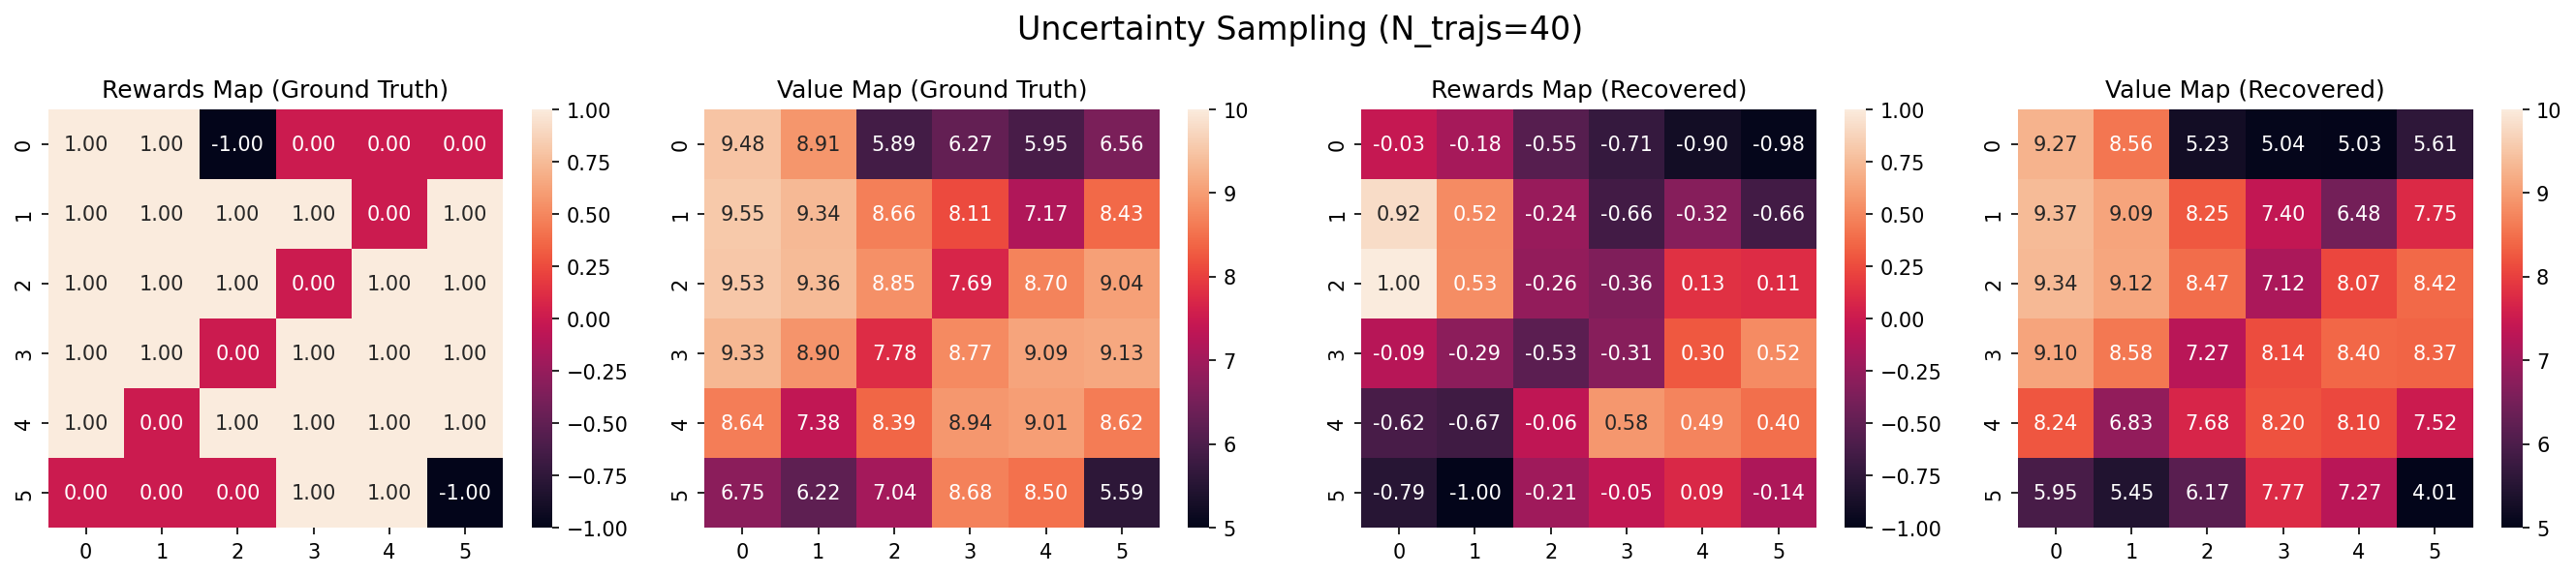

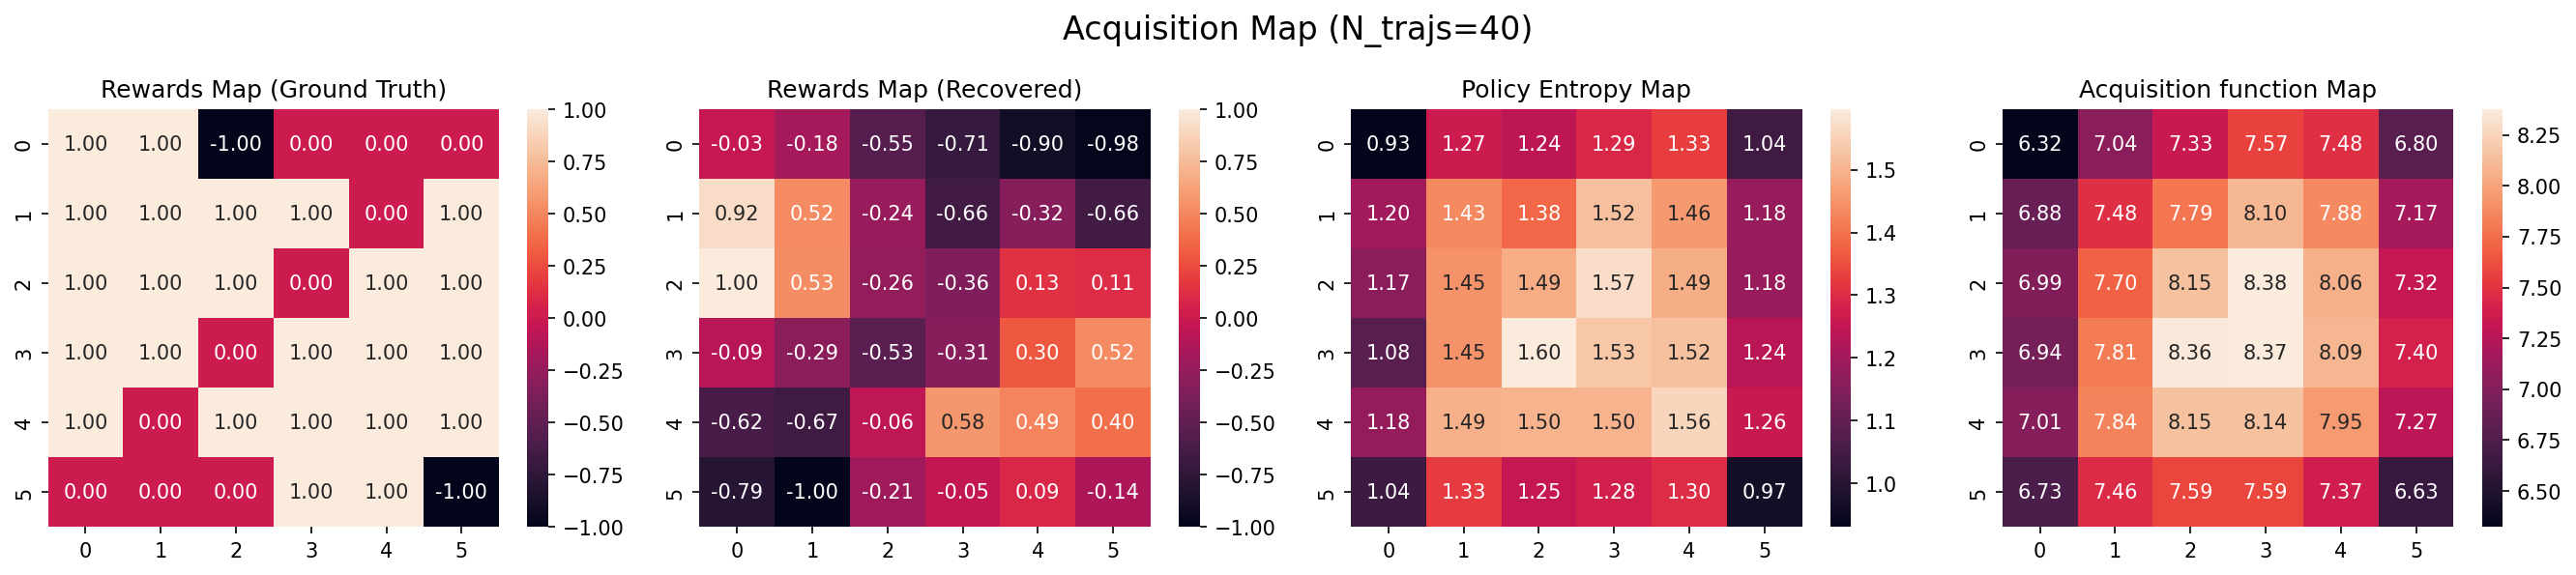

In [30]:
visualizer = Visualizer(history_deepmaxent_active, file_path=None, figsize=(18, 4), dpi=150)
n_trajs = 40
visualizer.draw_value_maps(search_idx=n_trajs)
visualizer.draw_acq_maps(search_idx=n_trajs)

In [ ]:
visualizer.objectworld_reward_policy(search_idx=n_trajs)

In [91]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np

from src.GridWorldMDP.objectworld_utils import draw_path, generate_demonstrations, init_object_world, visitation_frequency
from src.deepmaxent_irl_objectworld import run_deepmaxent_irl
from src.maxent_irl_objectworld import run_maxent_irl
from src.img_utils import Visualizer, get_evd, draw_evd
from src.argument_parser import get_parser, parse_args_str

PARSER = get_parser()

DEEP_MAXENT_ACTIVE_ARGS = """
--exp_name deepmaxent_active
--type object
--n_objects 16
--n_colours 2
--height 8
--width 8
--gamma 0.9
--act_random 0.3
--n_trajs 10
--l_traj 8
--learning_rate 0.0001
--n_iters 30
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 0.01
--hiddens 32 32 16 8
--device cuda
--active
--seed 3
--verbose 2
--architecture cnn
"""

# becareful of learning rate will cause nan
args = parse_args_str(PARSER, DEEP_MAXENT_ACTIVE_ARGS)
print(args.exp_name)
history_deepmaxent_active = run_deepmaxent_irl(args, init_start_pos=None)

deepmaxent_active
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
[INFO] Initialize trajectories
Visitation Frequency
[[2 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 2 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
[INFO - n_trajs:1] Training Deep MaxEnt IRL
DeepIRLCNN(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.25, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.25, inplace=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.25, inplace=False)
    )
    (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
    (4): Sequential(
     

  0%|          | 0/30 [00:00<?, ?it/s]

0


TypeError: conv2d() received an invalid combination of arguments - got (Sequential, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!Sequential!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!Sequential!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


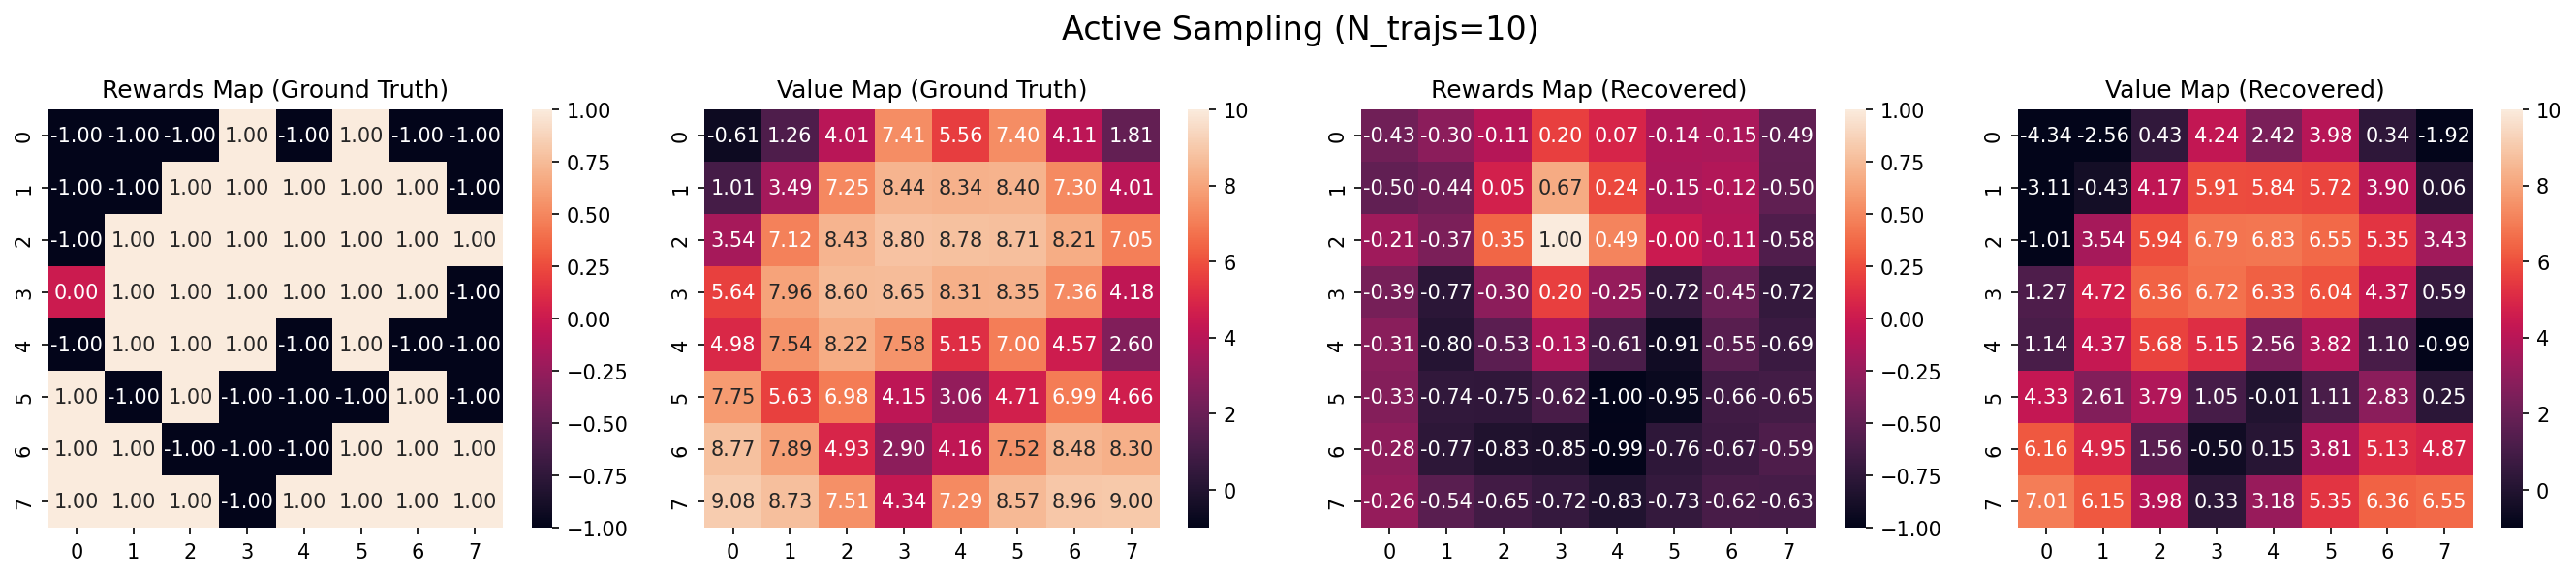

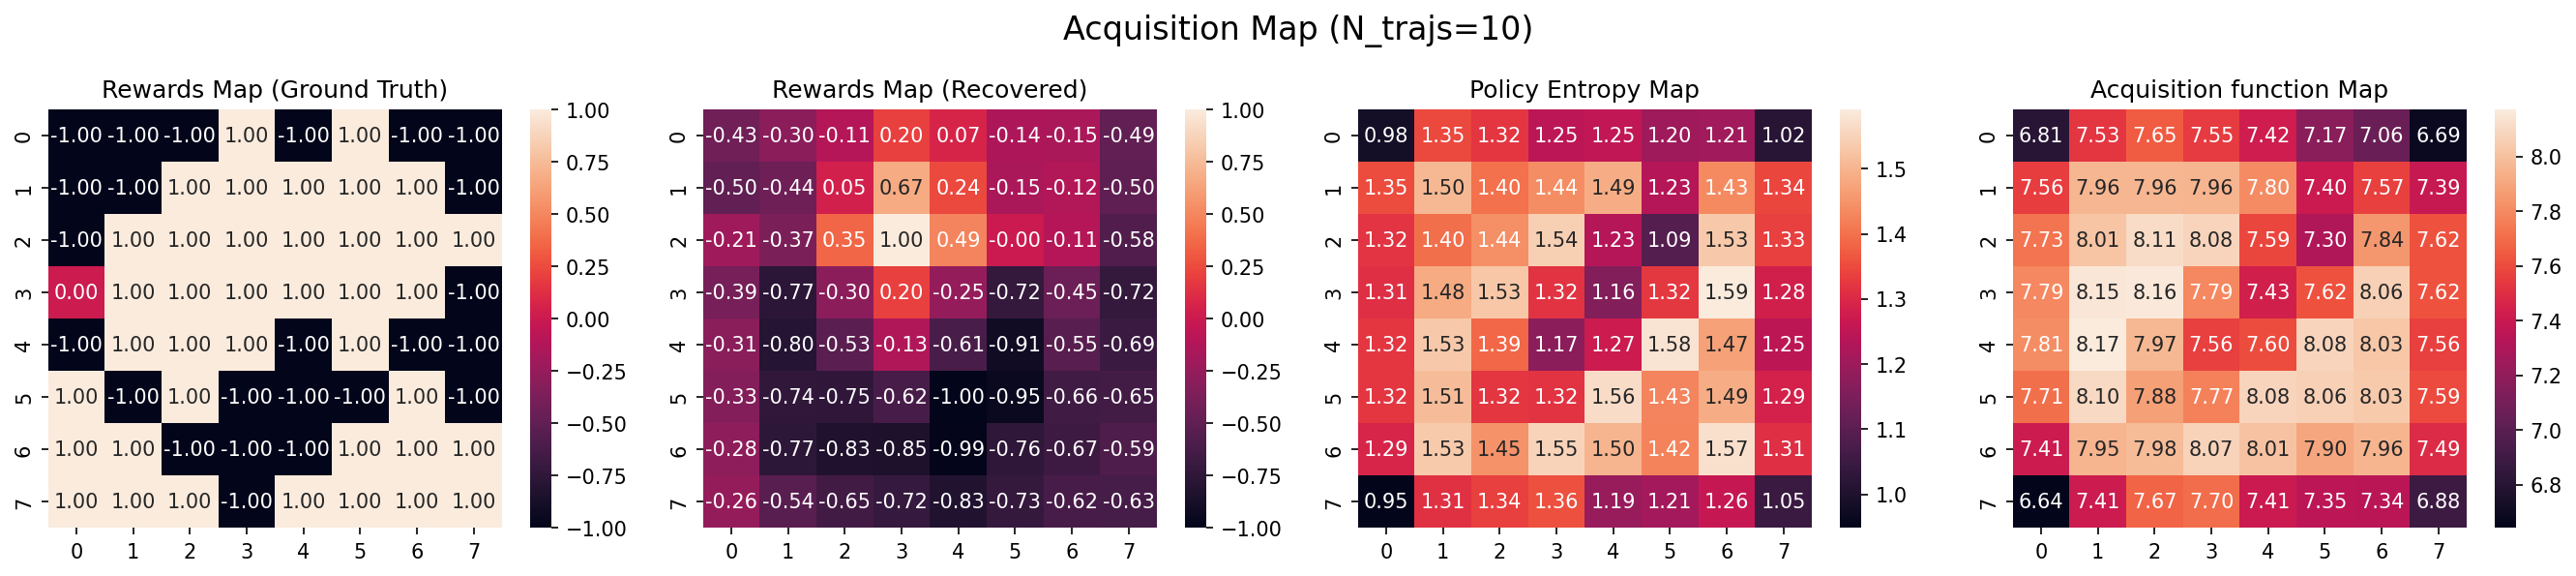

In [55]:
visualizer = Visualizer(history_deepmaxent_active, file_path=None, figsize=(18, 4), dpi=150)
n_trajs = 10
visualizer.draw_value_maps(search_idx=n_trajs)
visualizer.draw_acq_maps(search_idx=n_trajs)